# Scoring and Estimation

- **Scoring** refers to evaluating a fixed set of cards (e.g., a holding or a complete hand) based on poker hand rankings.
- **Strength estimation** refers to using Monte Carlo simulation to estimate the probability that a given holding will win a street involving multiple opponents.

For clarity, we keep all imports centralized in the following cell.

In [1]:
# imports for third-party libraries (you may need to install some of these via pip)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# imports from maverick
from maverick import Card, Deck, Holding, Hand, Suit, Rank
from maverick.utils import estimate_holding_strength, score_hand

## Scoring

You can use scoring to tell which of two sets of cards is stronger at the moment.

You can evaluate the score of a Holding using the `score` method like this:

In [2]:
deck = Deck.build().shuffle()
holding = Holding(cards=deck.deal(2))
holding, holding.score()

(7♥ J♦, (<HandType.HIGH_CARD: 1>, 100.1107))

You can also evaluate scores of hands:

In [3]:
deck = Deck.build().shuffle()
hand = Hand(private_cards=deck.deal(2), community_cards=deck.deal(3))
hand, hand.score()

(4♦ 9♠ 8♦ 5♥ J♣, (<HandType.HIGH_CARD: 1>, 100.1109080504))

The hand can be partial:

In [4]:
deck = Deck.build().shuffle()
hand = Hand(private_cards=deck.deal(2), community_cards=deck.deal(1))
hand, hand.score()

(6♣ 10♥ J♥, (<HandType.HIGH_CARD: 1>, 100.111006))

If you want more control, you can use the utility function directly. It is called `score_hands`, but you can give it any number of cards less then or equal to 5.

In [5]:
cards: list[Card] = deck.deal(1)
cards, score_hand(cards)

([8♣], (<HandType.HIGH_CARD: 1>, 100.08))

In [6]:
cards: list[Card] = deck.deal(3)
cards, score_hand(cards)

([3♣, 5♦, 6♥], (<HandType.HIGH_CARD: 1>, 100.060503))

In [7]:
cards: list[Card] = deck.deal(5)
cards, score_hand(cards)

([A♠, 4♠, 9♥, 2♦, 5♥], (<HandType.HIGH_CARD: 1>, 100.1409050402))

Of course, the score of a set of cards is not meaningful by itself. It simply provides a way to compare two sets of cards to determine which is currently stronger. If you want a more informative measure of a set of cards' strength, you should use strength estimation.

## Strength Estimation

For estimating the stregth of a set of cards, we use a Monte-Carlo simulation. What it returns is the probability of winning a street against a number of opponents.

Here is an example for estimating the strength of a pair of aces:

In [8]:
pair_of_aces = Holding(cards=[
    Card(suit='S', rank=14),  # Ace of Spades
    Card(suit='H', rank=14)   # Ace of Hearts
])
prob = pair_of_aces.estimate_strength(n_simulations=1000, n_players=8)
print(f"Estimated strength of {pair_of_aces.cards} is {prob:.2%}\n")

Estimated strength of [A♠, A♥] is 74.40%



If you need more control, you can use the utility function directly:

In [9]:
cards = Deck.build().shuffle().deal(2)
prob = estimate_holding_strength(cards, n_simulations=1000, n_players=8)
print(f"Estimated strength of {cards} is {prob:.2%}\n")

Estimated strength of [A♦, 9♣] is 21.50%



The utility function `estimate_holding_strength` was originally designed for estimating holdings, but just like with the scorer, you can pass any number of cards less than or equal to 5.

In [10]:
# --------------------------------- Example with 3 cards ---------------------------------

cards = Deck.build().shuffle().deal(3)
prob = estimate_holding_strength(cards, n_simulations=1000, n_players=8)
print(f"Estimated strength of {cards} is {prob:.2%}")

# ------------------------------Example with a broadway hand ------------------------------

broadway = [
    Card(suit=Suit.HEARTS, rank=Rank.TEN),
    Card(suit=Suit.DIAMONDS, rank=Rank.JACK),
    Card(suit=Suit.CLUBS, rank=Rank.QUEEN),
    Card(suit=Suit.SPADES, rank=Rank.KING),
    Card(suit=Suit.HEARTS, rank=Rank.ACE),
]
prob = estimate_holding_strength(broadway, n_simulations=1000, n_players=8)
print(f"Estimated strength of {broadway} is {prob:.2%}")

# --------------------------------Example with a royal flush ------------------------------

royal_flush = [
    Card(suit=Suit.SPADES, rank=Rank.TEN),
    Card(suit=Suit.SPADES, rank=Rank.JACK),
    Card(suit=Suit.SPADES, rank=Rank.QUEEN),
    Card(suit=Suit.SPADES, rank=Rank.KING),
    Card(suit=Suit.SPADES, rank=Rank.ACE),
]
prob = estimate_holding_strength(royal_flush, n_simulations=1000, n_players=8)
assert prob == 1.0
print(f"Estimated strength of {royal_flush} is {prob:.2%}")

Estimated strength of [2♦, 5♣, K♠] is 6.70%
Estimated strength of [10♥, J♦, Q♣, K♠, A♥] is 96.80%
Estimated strength of [10♠, J♠, Q♠, K♠, A♠] is 100.00%


Running the same simulation a number of times would likely yield different probabilities. To get a more accurate estimation, we can visualize the distribution of probabilities for a pair of aces using a histogram.

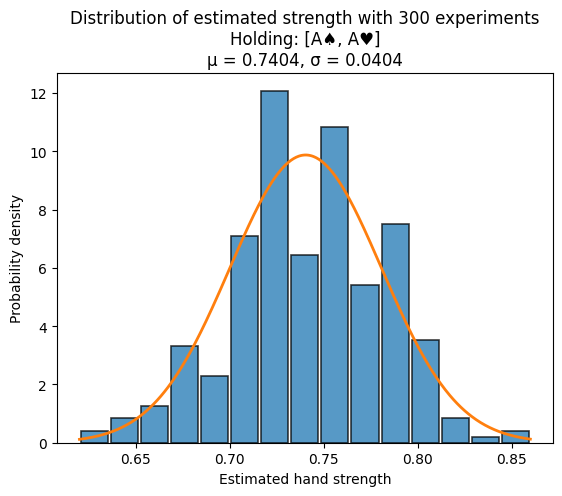

In [11]:
# Hyperparameters
n_experiment = 300
n_simulations = 100
n_players = 8
experiments = []

pair_of_aces = Holding(cards=[
    Card(suit='S', rank=14),  # Ace of Spades
    Card(suit='H', rank=14)   # Ace of Hearts
])

# Run experiments
for i in range(n_experiment):
    strength = pair_of_aces.estimate_strength(
        n_simulations=n_simulations,
        n_players=n_players
    )
    experiments.append(strength)

# Convert to numpy array
experiments = np.asarray(experiments)

# Fit Gaussian parameters
mu = experiments.mean()
sigma = experiments.std(ddof=1)

# Histogram as density
plt.hist(
    experiments,
    bins=15,
    density=True,
    rwidth=0.9,
    edgecolor="black",
    linewidth=1.2,
    alpha=0.75
)

# NOTE: The parameter ``density=True`` is crucial as it normalizes the histogram.
# Without this, the empirical histogram and the Gaussian PDF would be on different scales.

# Gaussian PDF
x = np.linspace(experiments.min(), experiments.max(), 500)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, linewidth=2)

# Formatting
plt.xlabel("Estimated hand strength")
plt.ylabel("Probability density")
plt.title((
    f"Distribution of estimated strength with {n_experiment} experiments\n"
    f"Holding: {pair_of_aces.cards}\n"
    f"\u03BC = {mu:.4f}, \u03C3 = {sigma:.4f}"
))

# Show plot
plt.show()